### Imports

In [1]:
# loading
import os
from glob import glob

# data
import math
import numpy as np
import pandas as pd

# visual
import matplotlib as mpl
import matplotlib.pyplot as plt


# metrics
from sklearn.metrics import classification_report, confusion_matrix

print('All packages imported!')

All packages imported!


### Helpers

In [2]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['font.size'] = 9

# Latex document Text width
latex_width = 469.75502

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [3]:
def load_task_df(task_number):
    if task_number not in range(1, 5):
        raise ValueError("Invalid task number. Please provide a task number between 1 and 4.")

    task_fps = glob(f'ckpt/test_3/task_{task_number}_*/result.csv')
    dfs = []

    for fp in task_fps:
        subject = fp.split('/')[-2].split('_')[-1]
        df = pd.read_csv(fp)
        df['subject'] = subject
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


def loo_accuracy(df):
    acc_df = df.groupby(['subject'])[['pred', 'true']].apply(lambda x: (x['pred'] == x['true']).mean()).reset_index()
    acc_df.columns = ['subject', 'accuracy']
    return acc_df


def filter_outliers(df):
    acc_df = loo_accuracy(df)
    Q1 = acc_df['accuracy'].quantile(0.25)
    Q3 = acc_df['accuracy'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR

    filtered_subjects = acc_df[(acc_df['accuracy'] >= lower_bound)]['subject']
    removed_subjects = acc_df[~acc_df['subject'].isin(filtered_subjects)]['subject']

    if len(removed_subjects) > 0:
        print(f"Outliers: {', '.join(removed_subjects)}")
    else:
        print("No Outliers")
    print()

    return df[df['subject'].isin(filtered_subjects)]

In [4]:
def plot_acc_hist(df, lower_bound=0.50, save_fig=False, filename=""):
    if save_fig and len(filename) == 0:
        raise ValueError("Please provide a filename to save the figure.")
    
    acc_df = loo_accuracy(df)

    fig, ax = plt.subplots(figsize=(set_size(height=0.5*latex_width)))

    bins = np.arange(lower_bound, 1.05, 0.025)
    proportions, bins, patches = ax.hist(acc_df['accuracy'], bins=bins, weights=np.ones(len(acc_df)) / len(acc_df), edgecolor='black')
    ax.set_xlim([lower_bound, 1])
    '''
    if max(proportions) % 2:
        ax.set_ylim([0, max(proportions) + 0.02])
    else:
        ax.set_ylim([0, max(proportions) + 0.01])
    '''
    ax.set_ylim([0, 0.3])

    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Proportion')


    if save_fig:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


def plot_classification_report(df, save_fig=False, filename=""):
    if save_fig and len(filename) == 0:
        raise ValueError("Please provide a filename to save the figure.")

    cm = confusion_matrix(df['true'], df['pred'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(set_size()))

    cax = plt.pcolormesh(cm, cmap='viridis', vmin=0, vmax=1, edgecolors='k', linewidth=0.5)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.invert_yaxis()

    cbar = plt.colorbar(fraction=0.046, pad=0.04, shrink=0.5)
    cbar.set_label('Proportion', rotation=270)
    cbar.set_ticks(np.arange(0, 1.1, 1))
    

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    # Add accuracy values to each entry
    for i in range(len(cm)):
        for j in range(len(cm)):
            if cm[i, j] >= 0.01:
                plt.text(j + 0.5, i + 0.5, round(cm[i, j], 2),
                         ha='center', va='center', color='black' if cm[i, j] > 0.5 else 'white', fontsize=7)

    # Add xticks for every class
    plt.xticks(np.arange(0.5, len(cm), 1), range(len(cm)))
    plt.yticks(np.arange(0.5, len(cm), 1), range(len(cm)))

    if save_fig:
        plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()

### Results

##########
# TASK 1 #
##########
No Outliers

        accuracy
count  71.000000
mean    0.929678
std     0.062339
min     0.767497
25%     0.892526
50%     0.955865
75%     0.978009
max     0.996528
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10187
           1       0.98      0.96      0.97      5090
           2       0.99      0.99      0.99      5107
           3       0.98      1.00      0.99      5101
           4       0.96      1.00      0.98      5097
           5       0.93      0.87      0.90      5083
           6       0.96      0.95      0.95      5009
           7       0.89      0.87      0.88      4852
           8       0.87      0.89      0.88      5004
           9       0.81      0.91      0.86      4963
          10       0.81      0.75      0.78      5026

    accuracy                           0.93     60519
   macro avg       0.92      0.92      0.92     60519
weighted avg       0.93      0.93      0.93

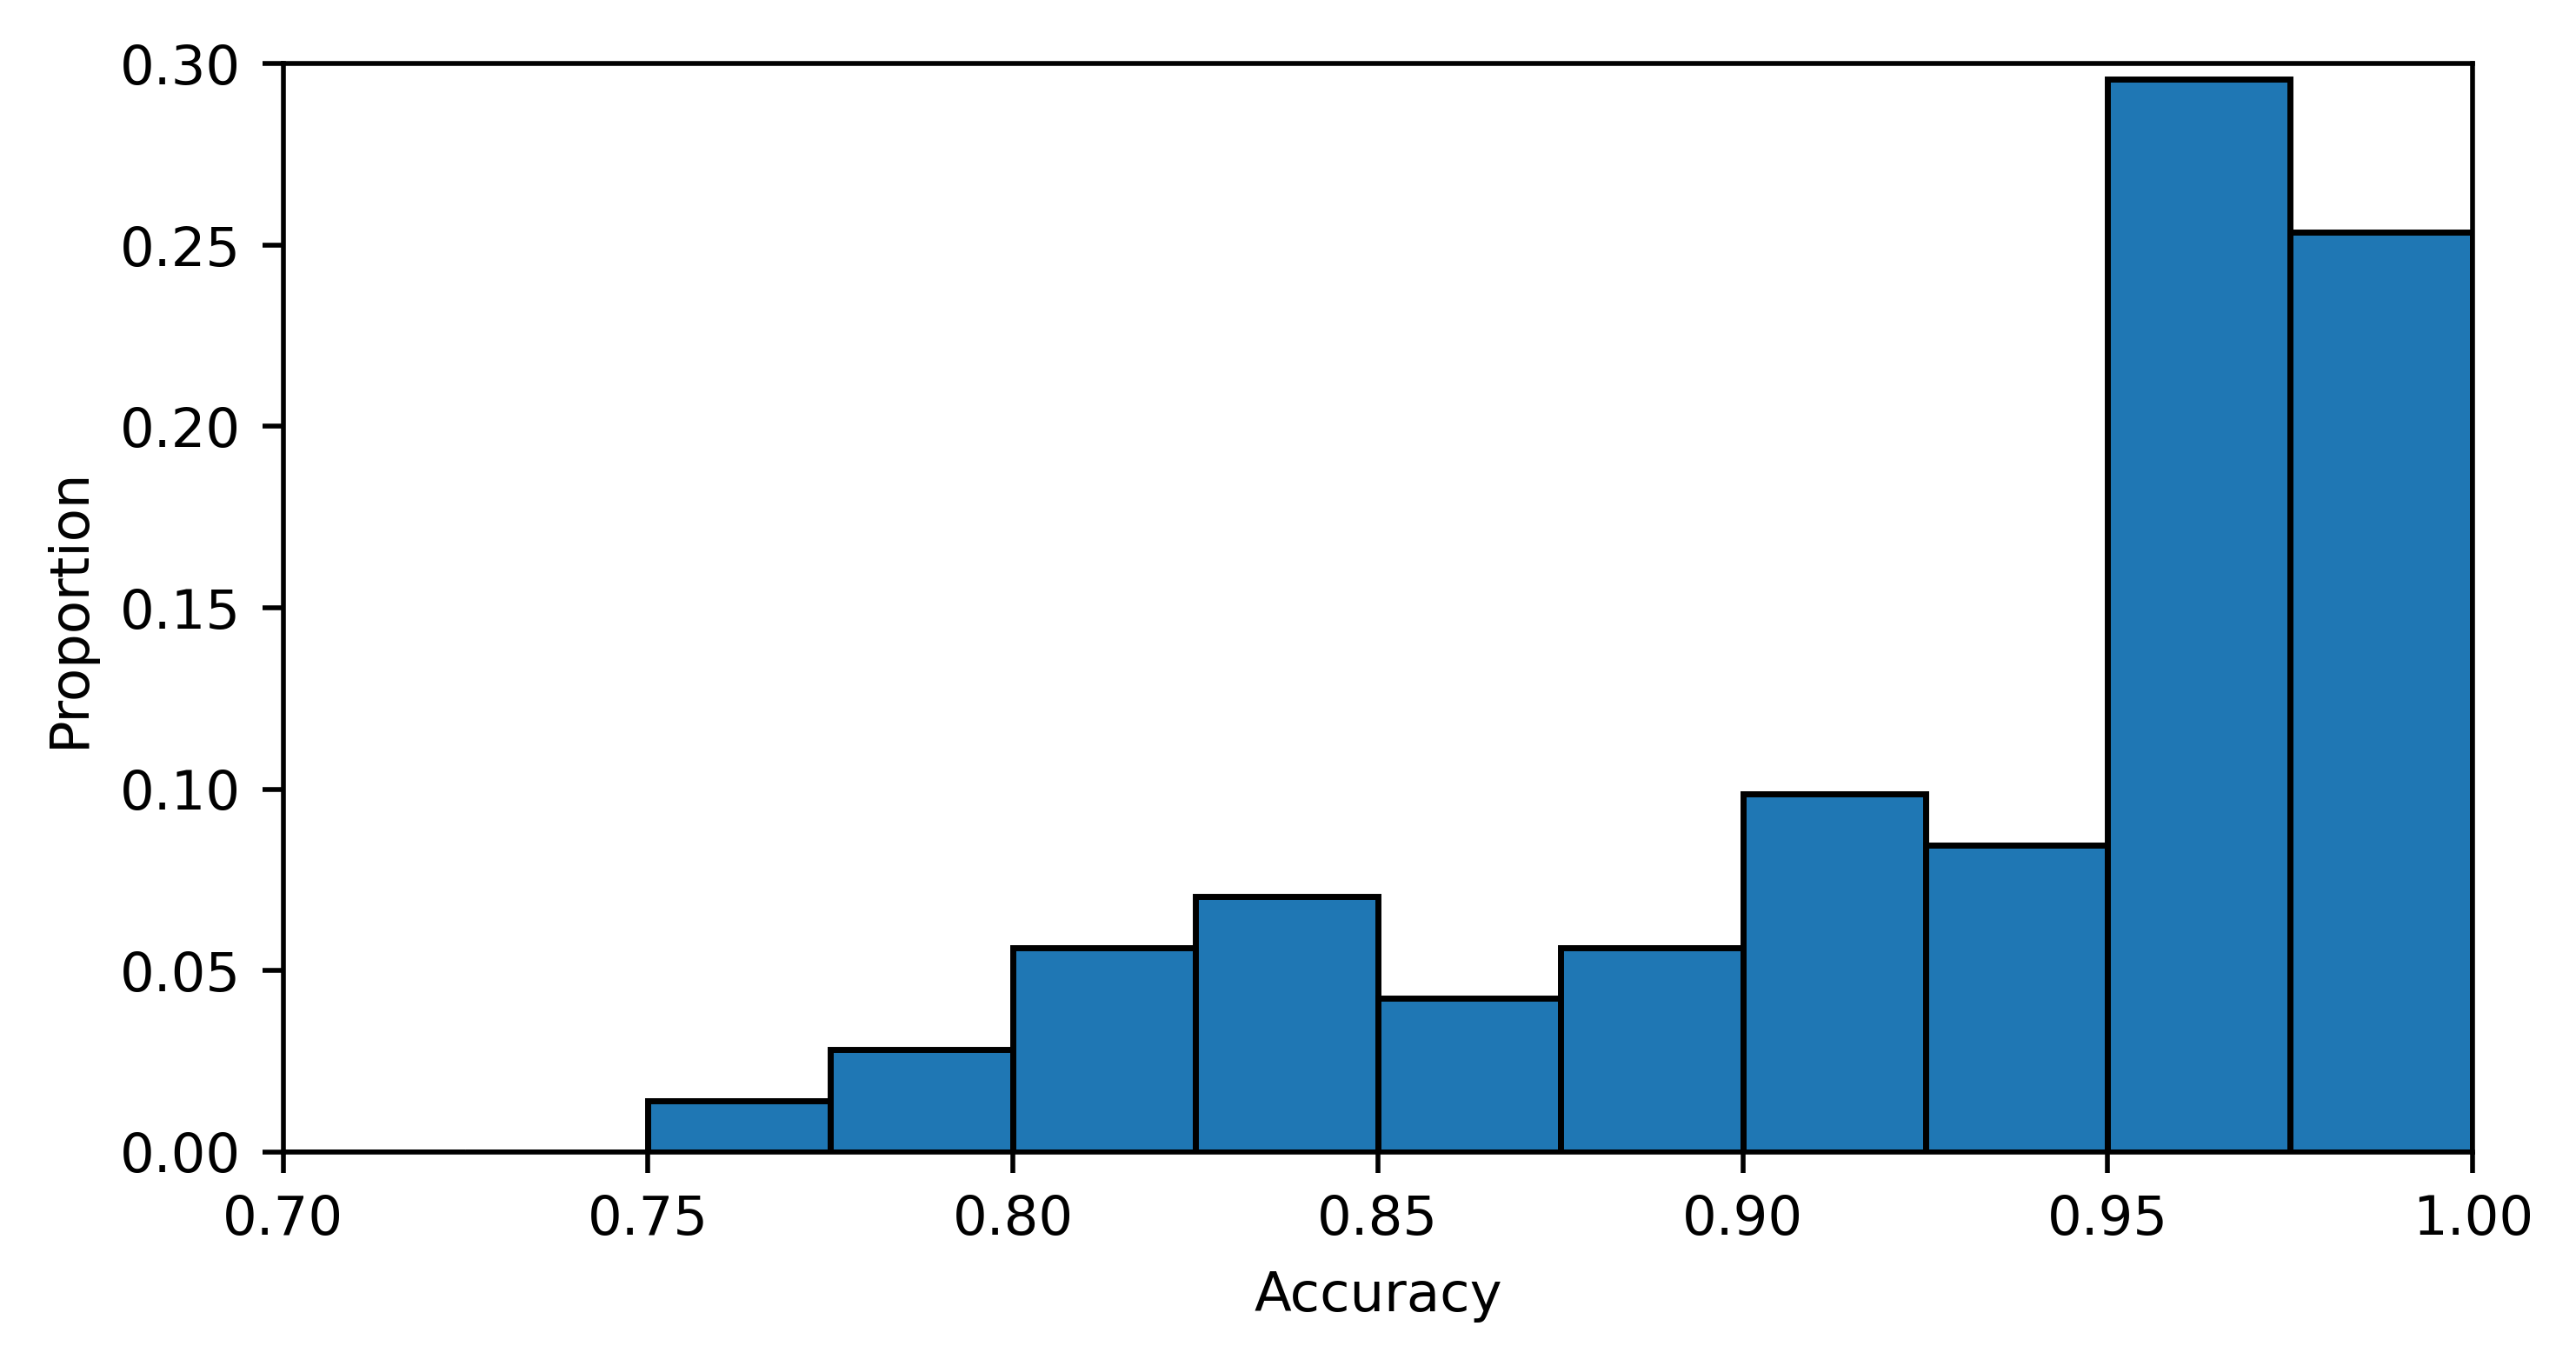

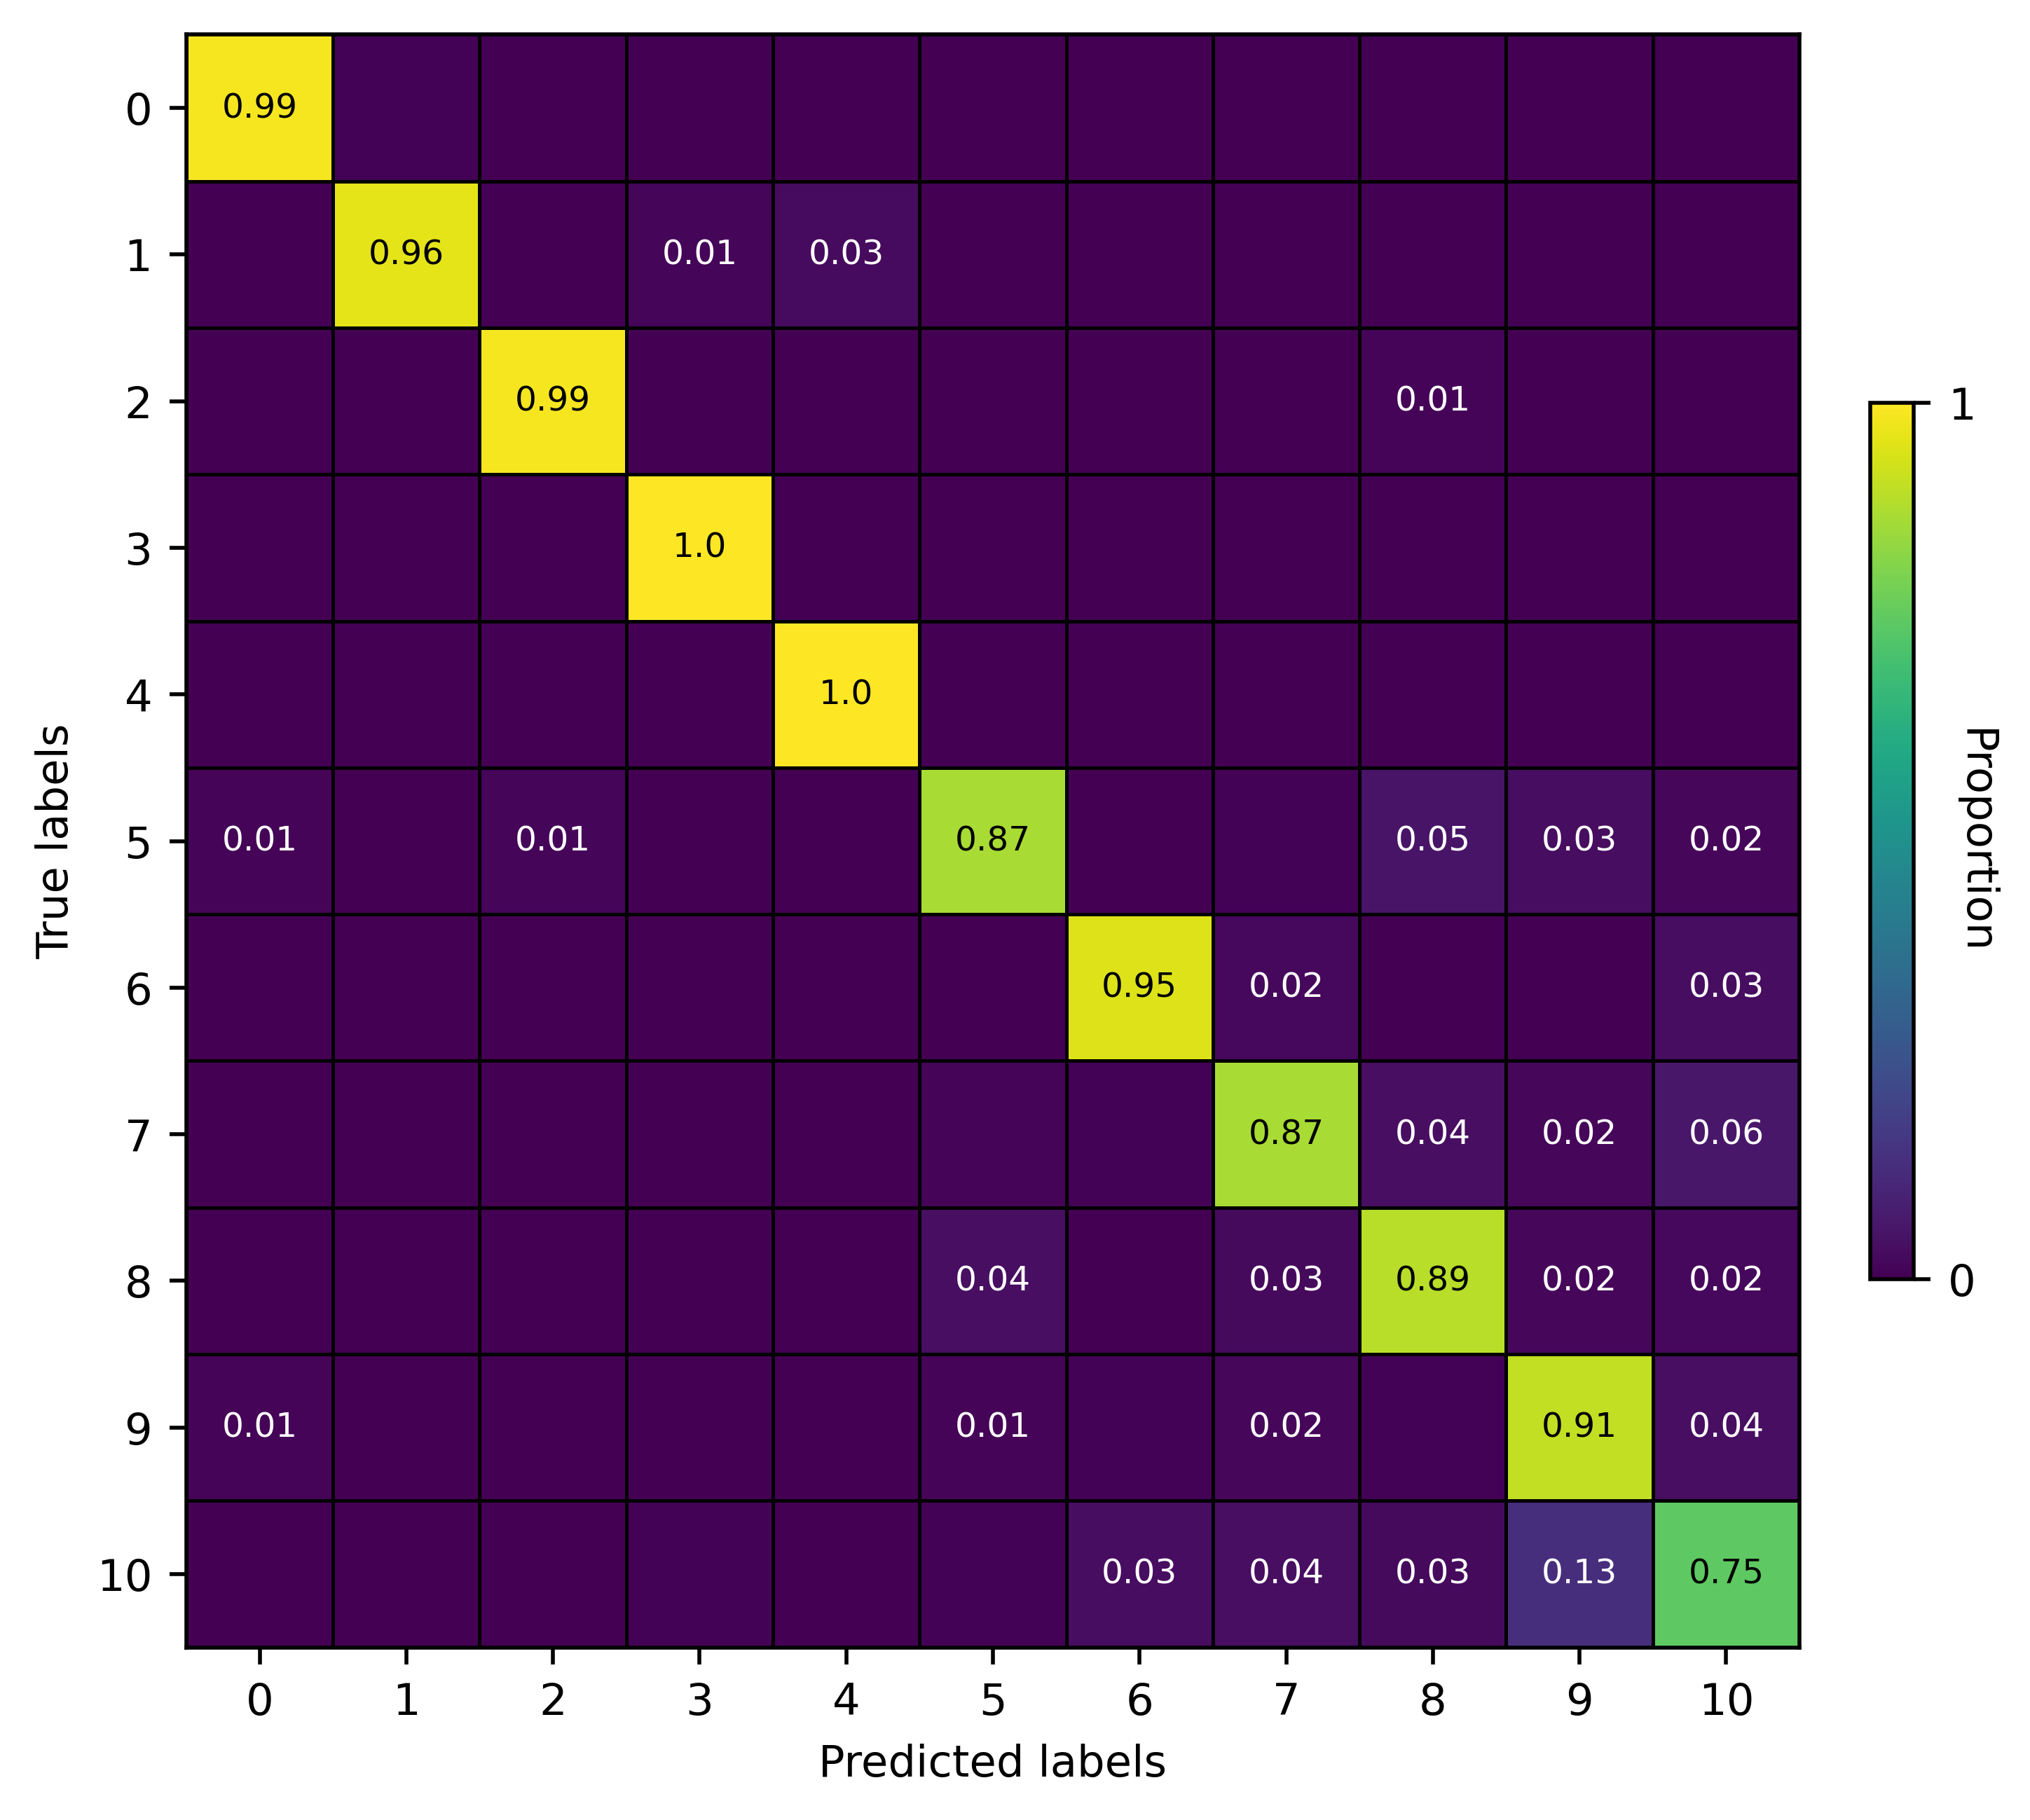

##########
# TASK 2 #
##########
Outliers: 2

        accuracy
count  71.000000
mean    0.890544
std     0.077876
min     0.642857
25%     0.839467
50%     0.898920
75%     0.958254
max     0.999228
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10187
           1       0.90      0.93      0.91      5090
           2       0.96      0.95      0.96      5107
           3       0.97      0.98      0.97      5101
           4       0.80      0.97      0.88      5097
           5       0.93      0.90      0.91     10049
           6       0.91      0.80      0.85      5003
           7       0.92      0.86      0.89      5027
           8       0.94      0.87      0.90      4955
           9       0.85      0.83      0.84      5018
          10       0.87      0.93      0.90     10098
          11       0.82      0.76      0.79      5028
          12       0.83      0.87      0.85      4966
          13       0.82      0.89      0.86 

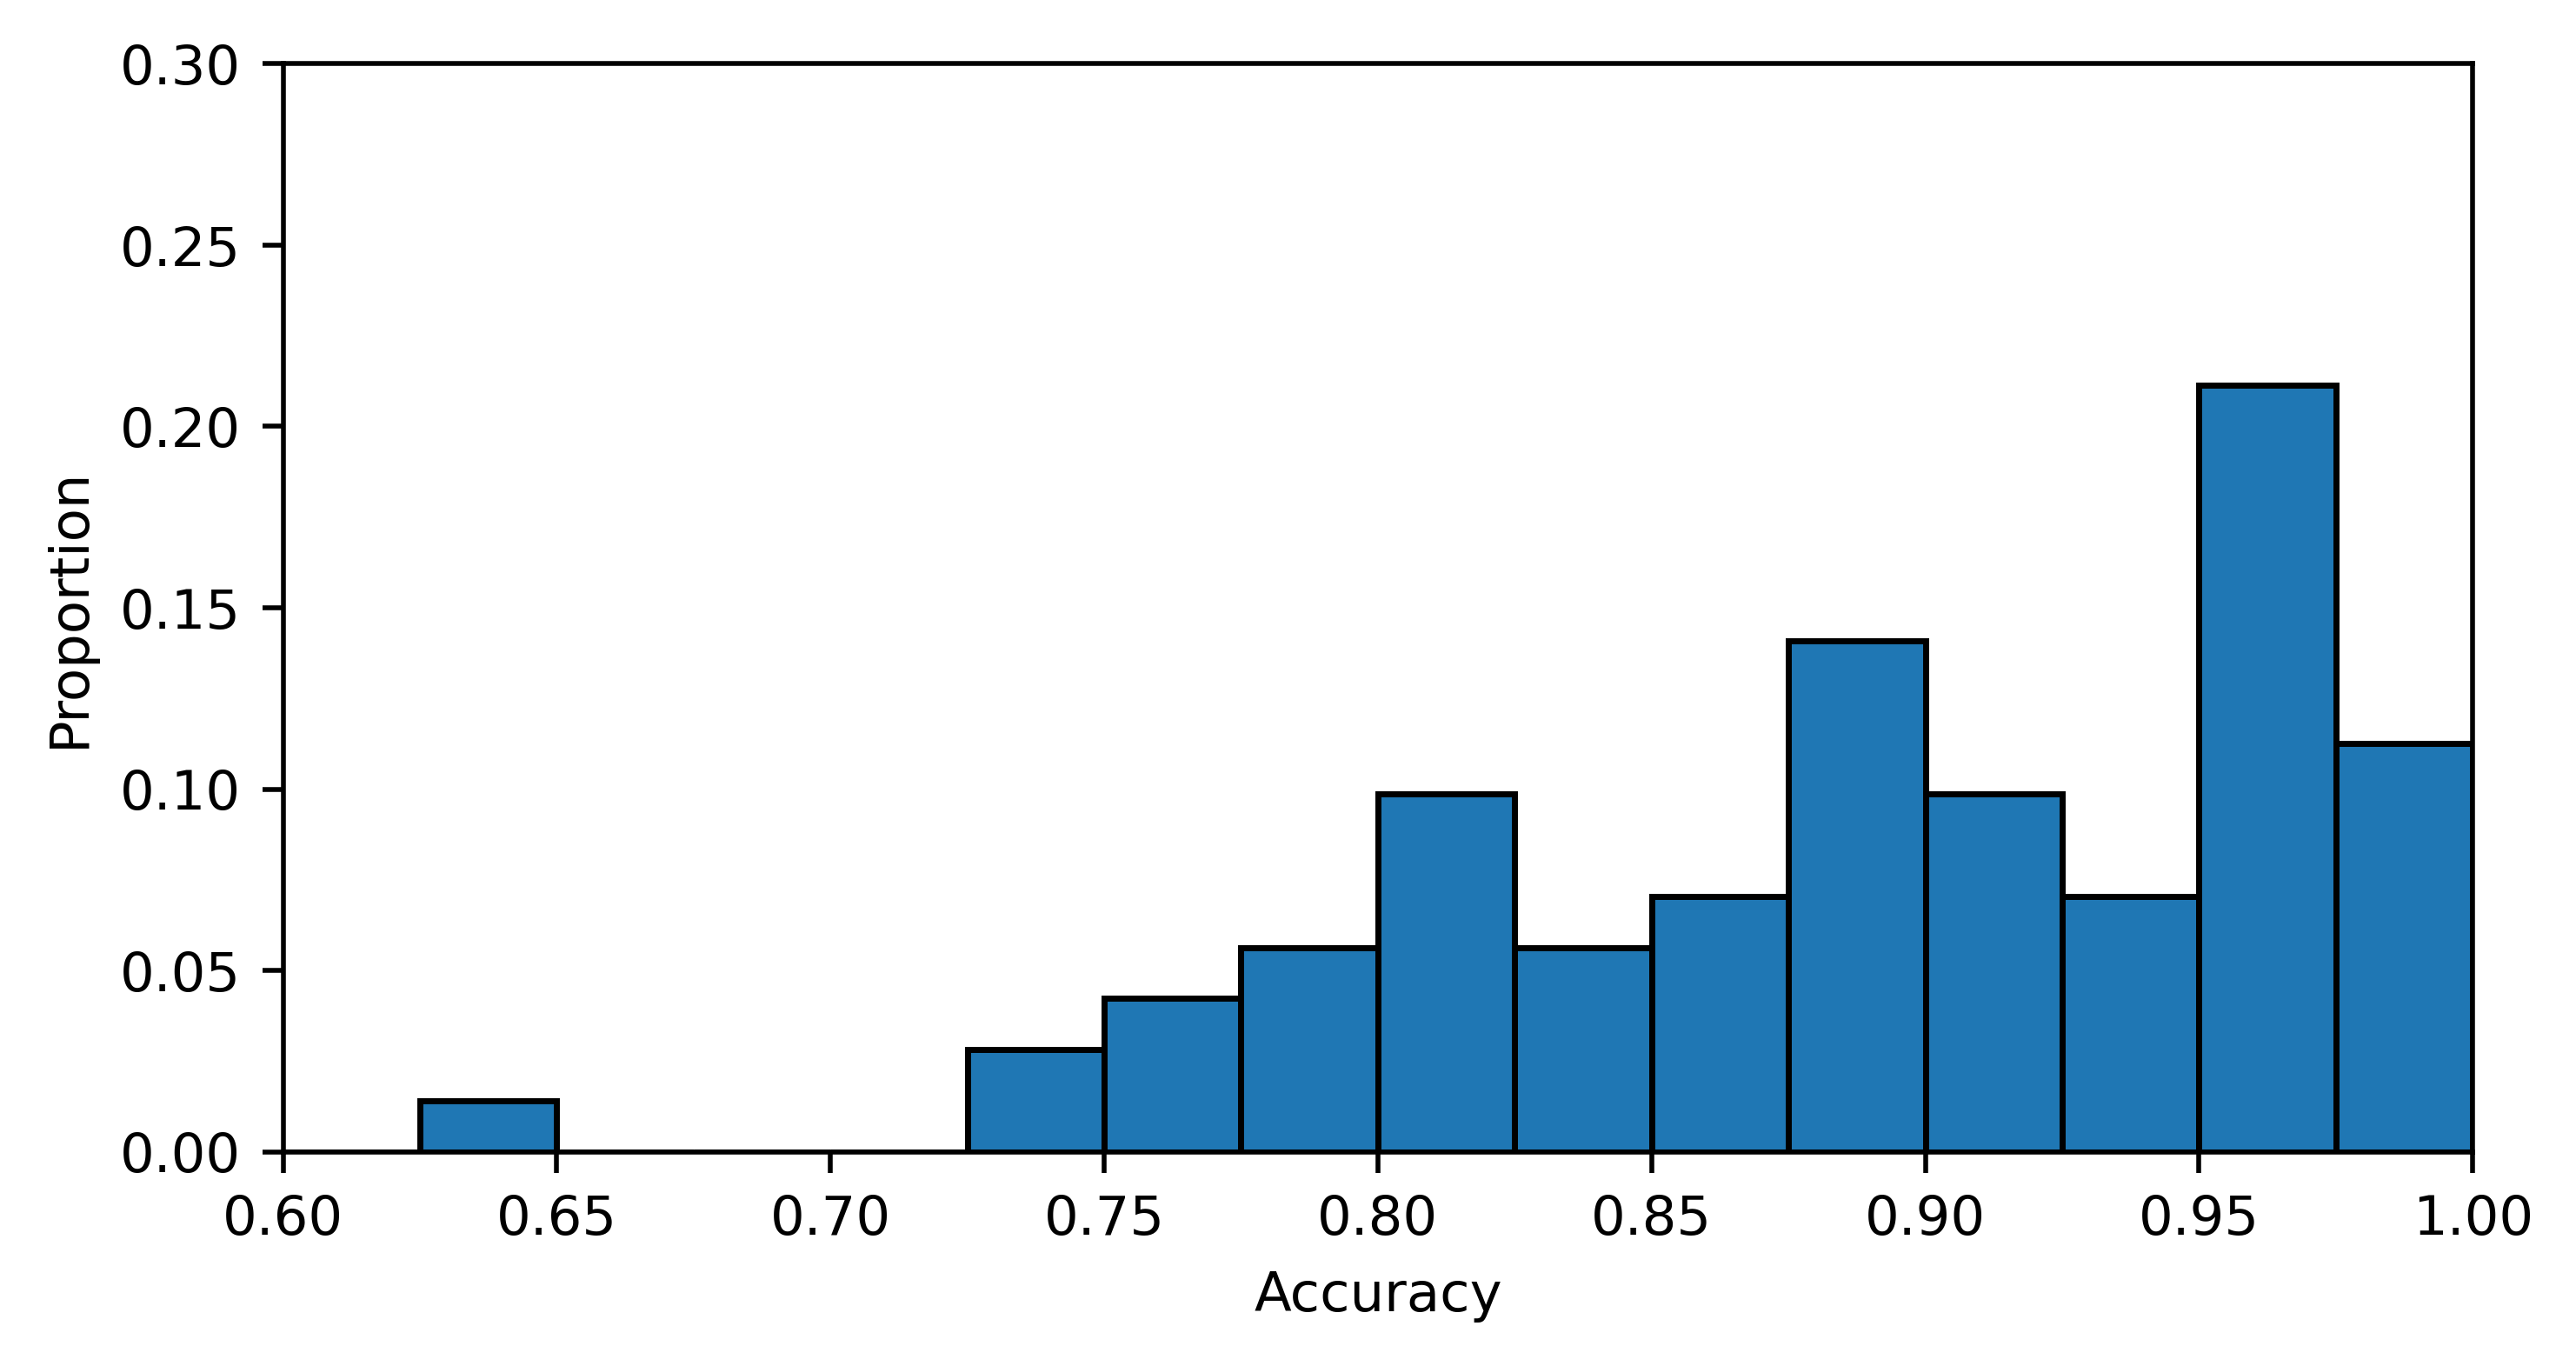

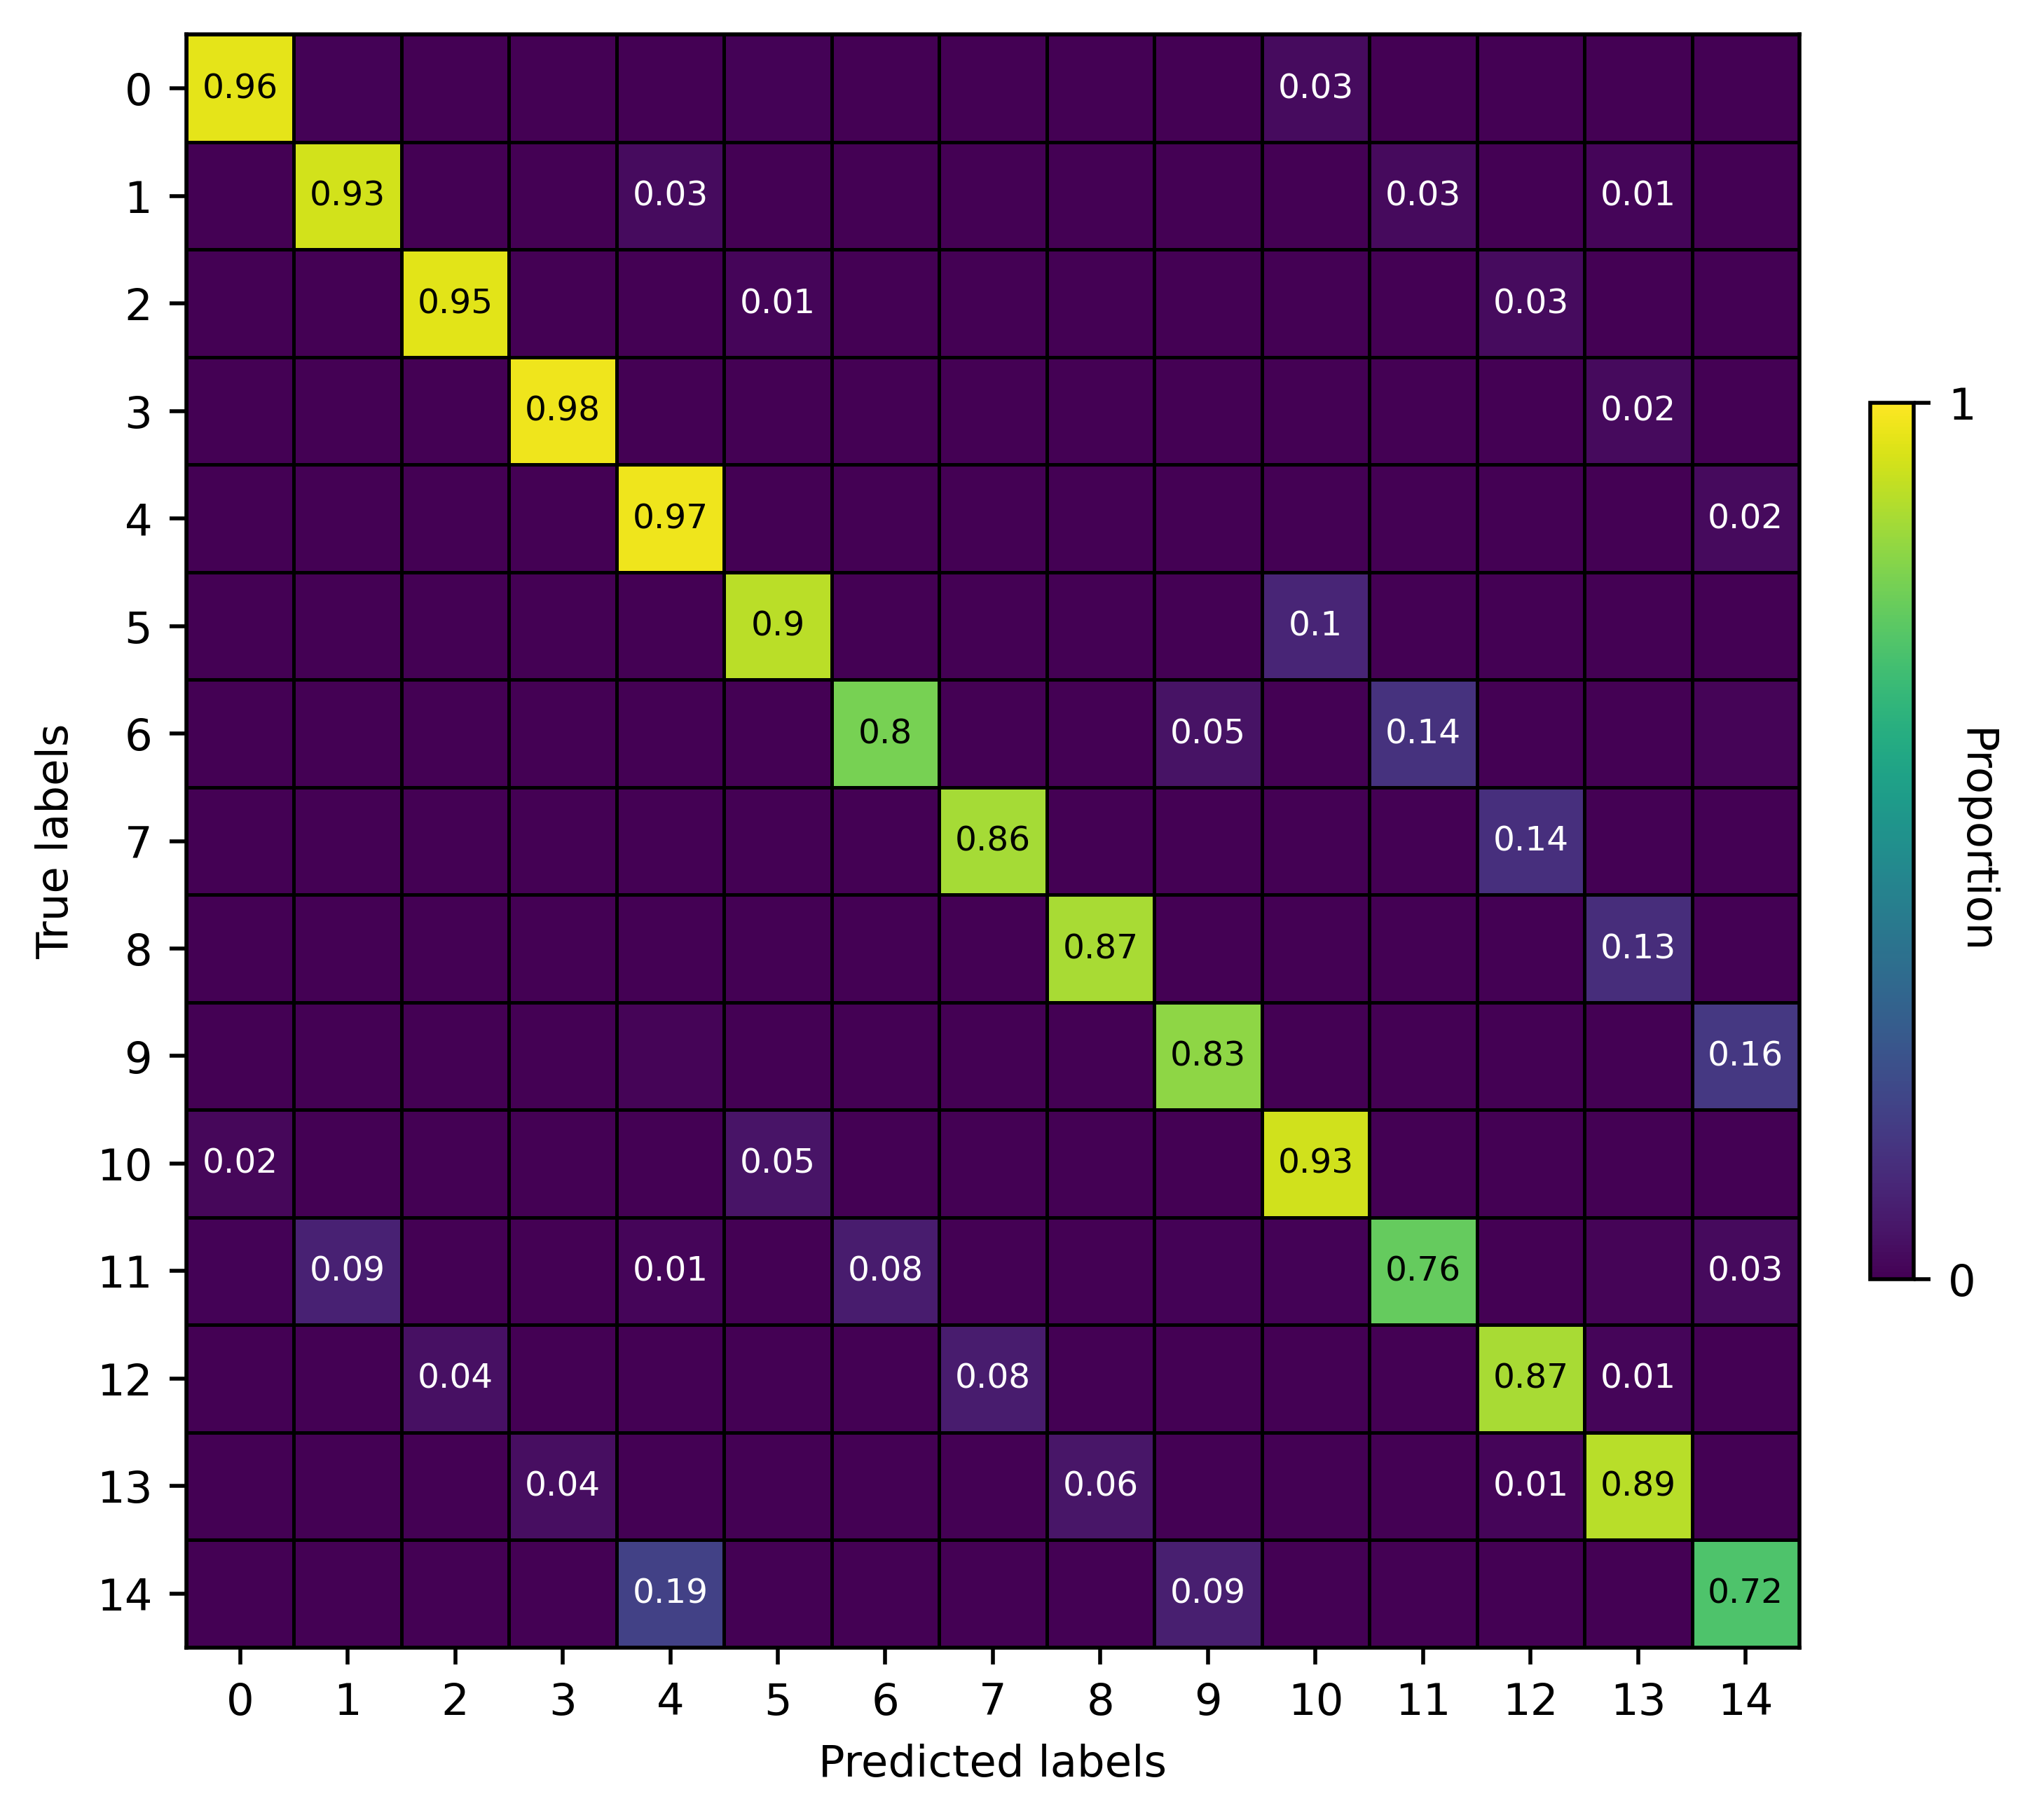

##########
# TASK 3 #
##########
Outliers: 62

        accuracy
count  71.000000
mean    0.715658
std     0.068660
min     0.455846
25%     0.678816
50%     0.726461
75%     0.762662
max     0.832602
              precision    recall  f1-score   support

           0       0.67      0.70      0.69     10187
           1       0.66      0.68      0.67      5090
           2       0.78      0.83      0.81      5107
           3       0.74      0.83      0.78      5101
           4       0.55      0.74      0.63      5097
           5       0.68      0.67      0.68     10049
           6       0.66      0.63      0.65      5003
           7       0.69      0.63      0.66      5027
           8       0.67      0.66      0.67      4955
           9       0.63      0.62      0.62      5018
          10       0.75      0.75      0.75     10098
          11       0.57      0.52      0.54      5028
          12       0.67      0.63      0.65      4966
          13       0.66      0.69      0.68

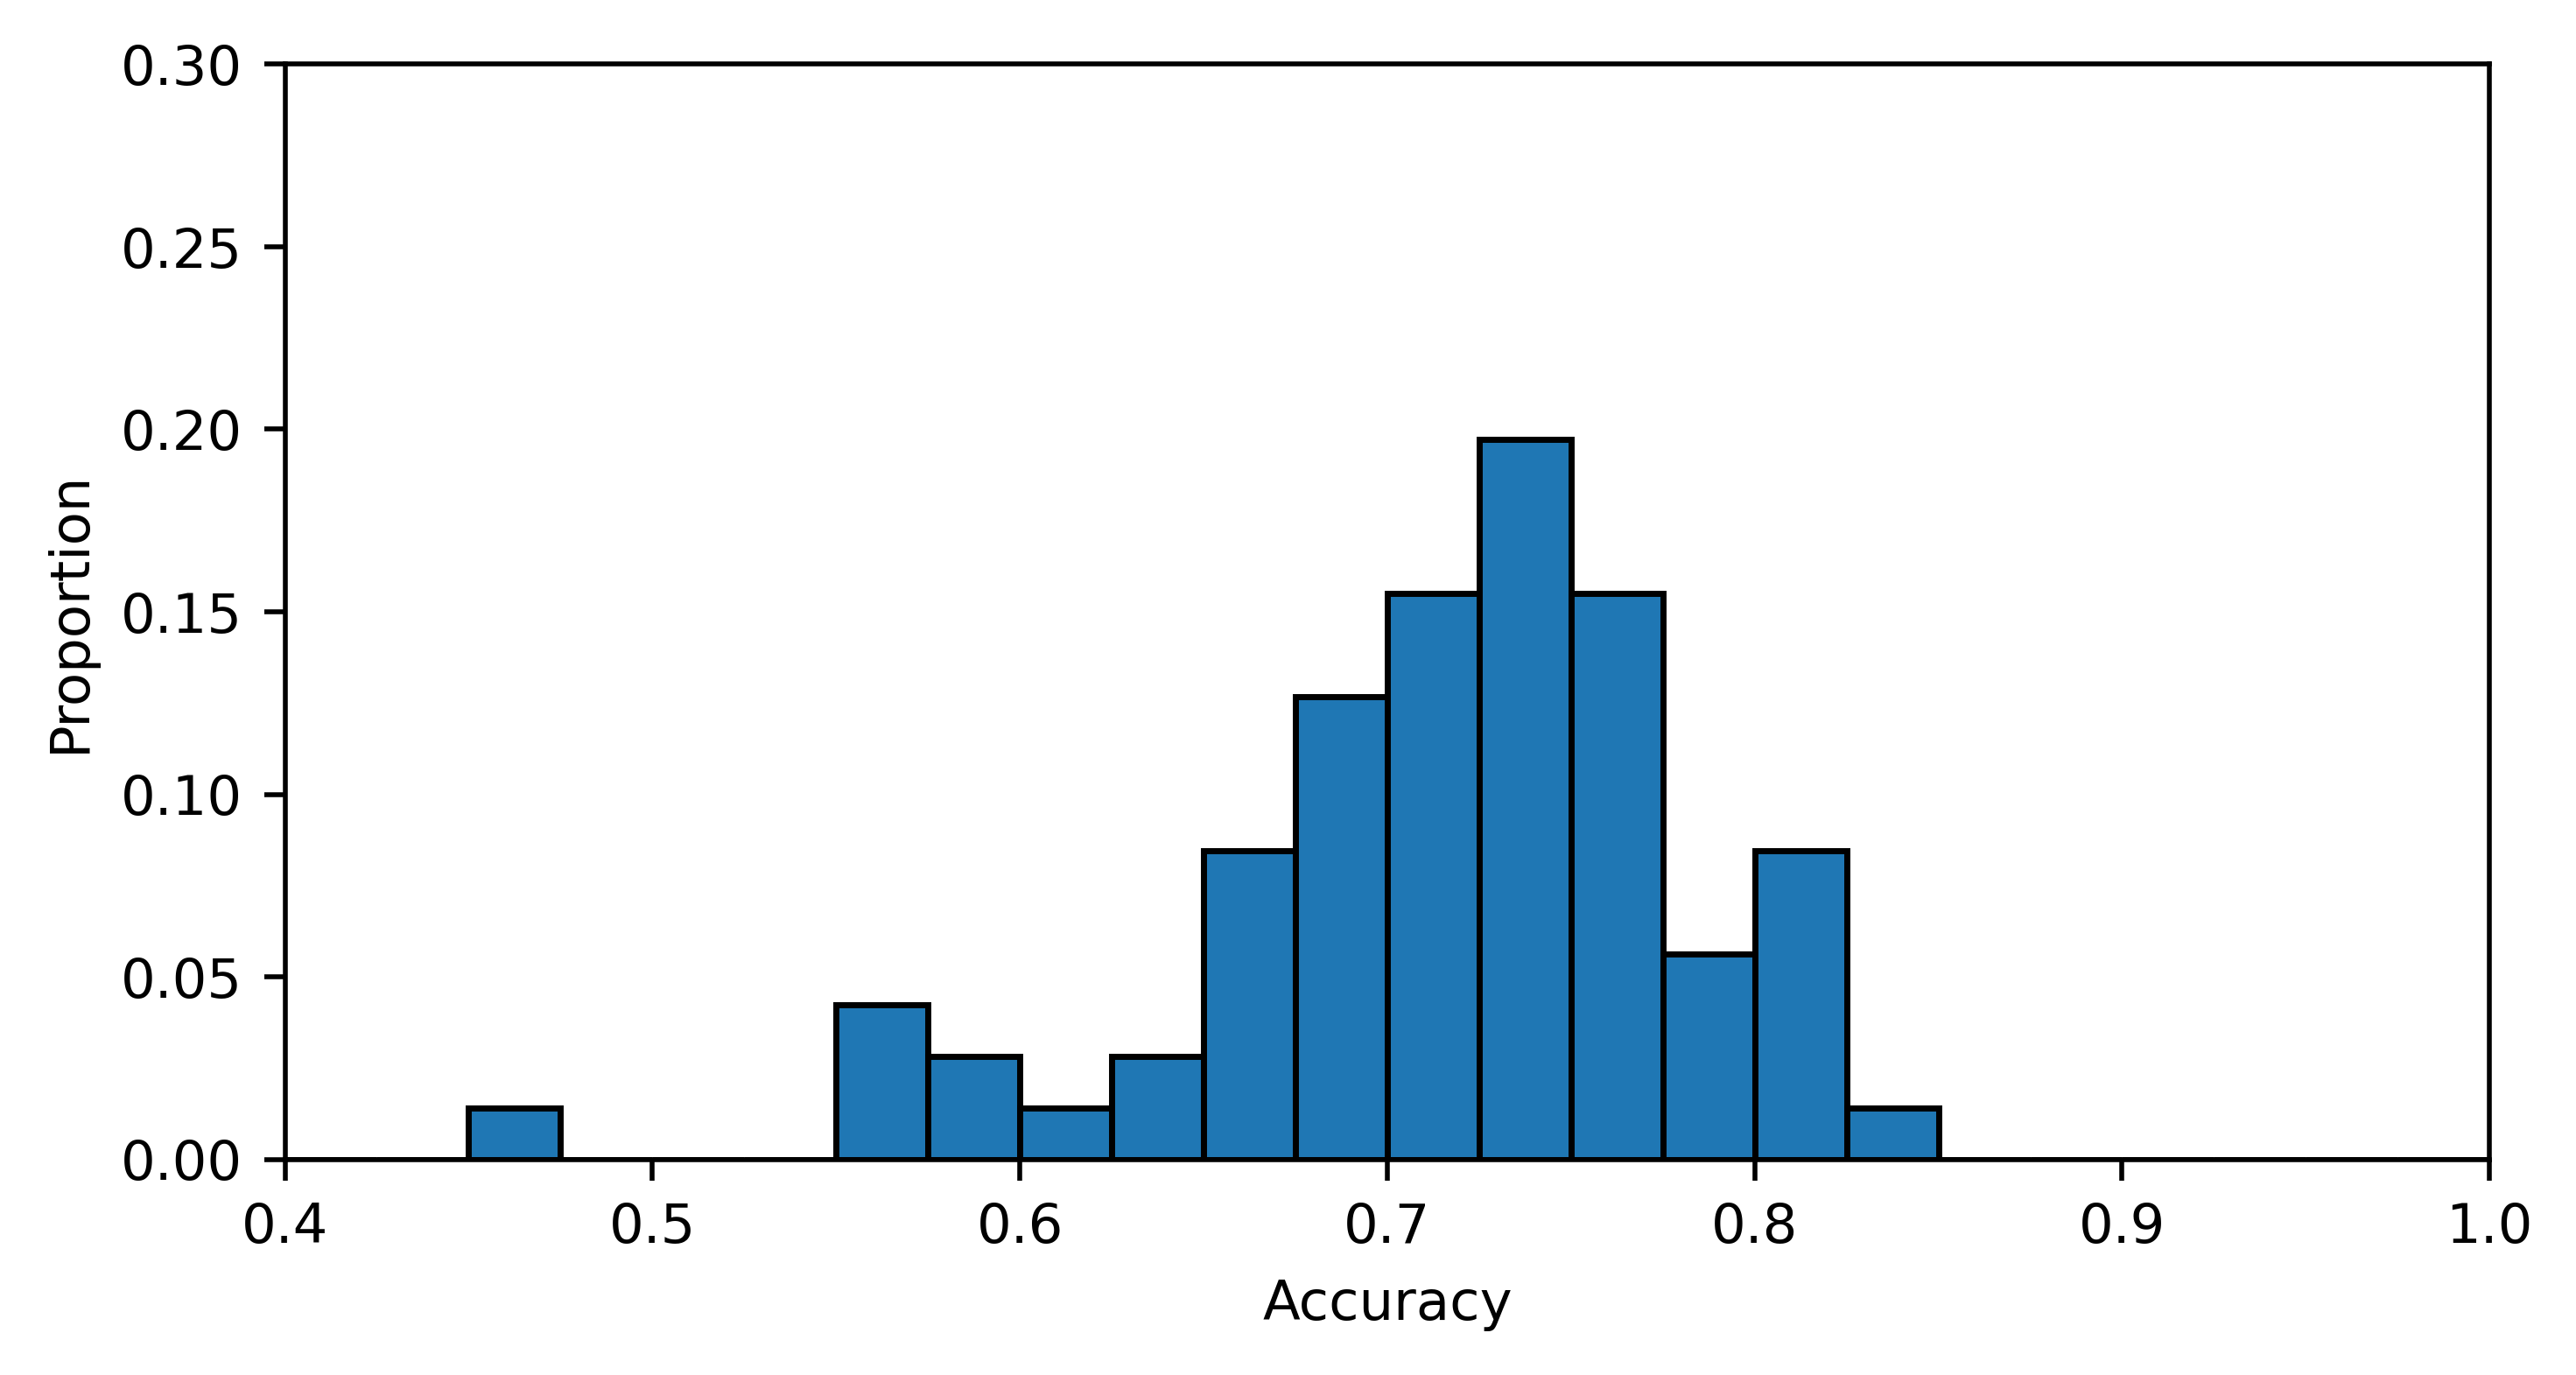

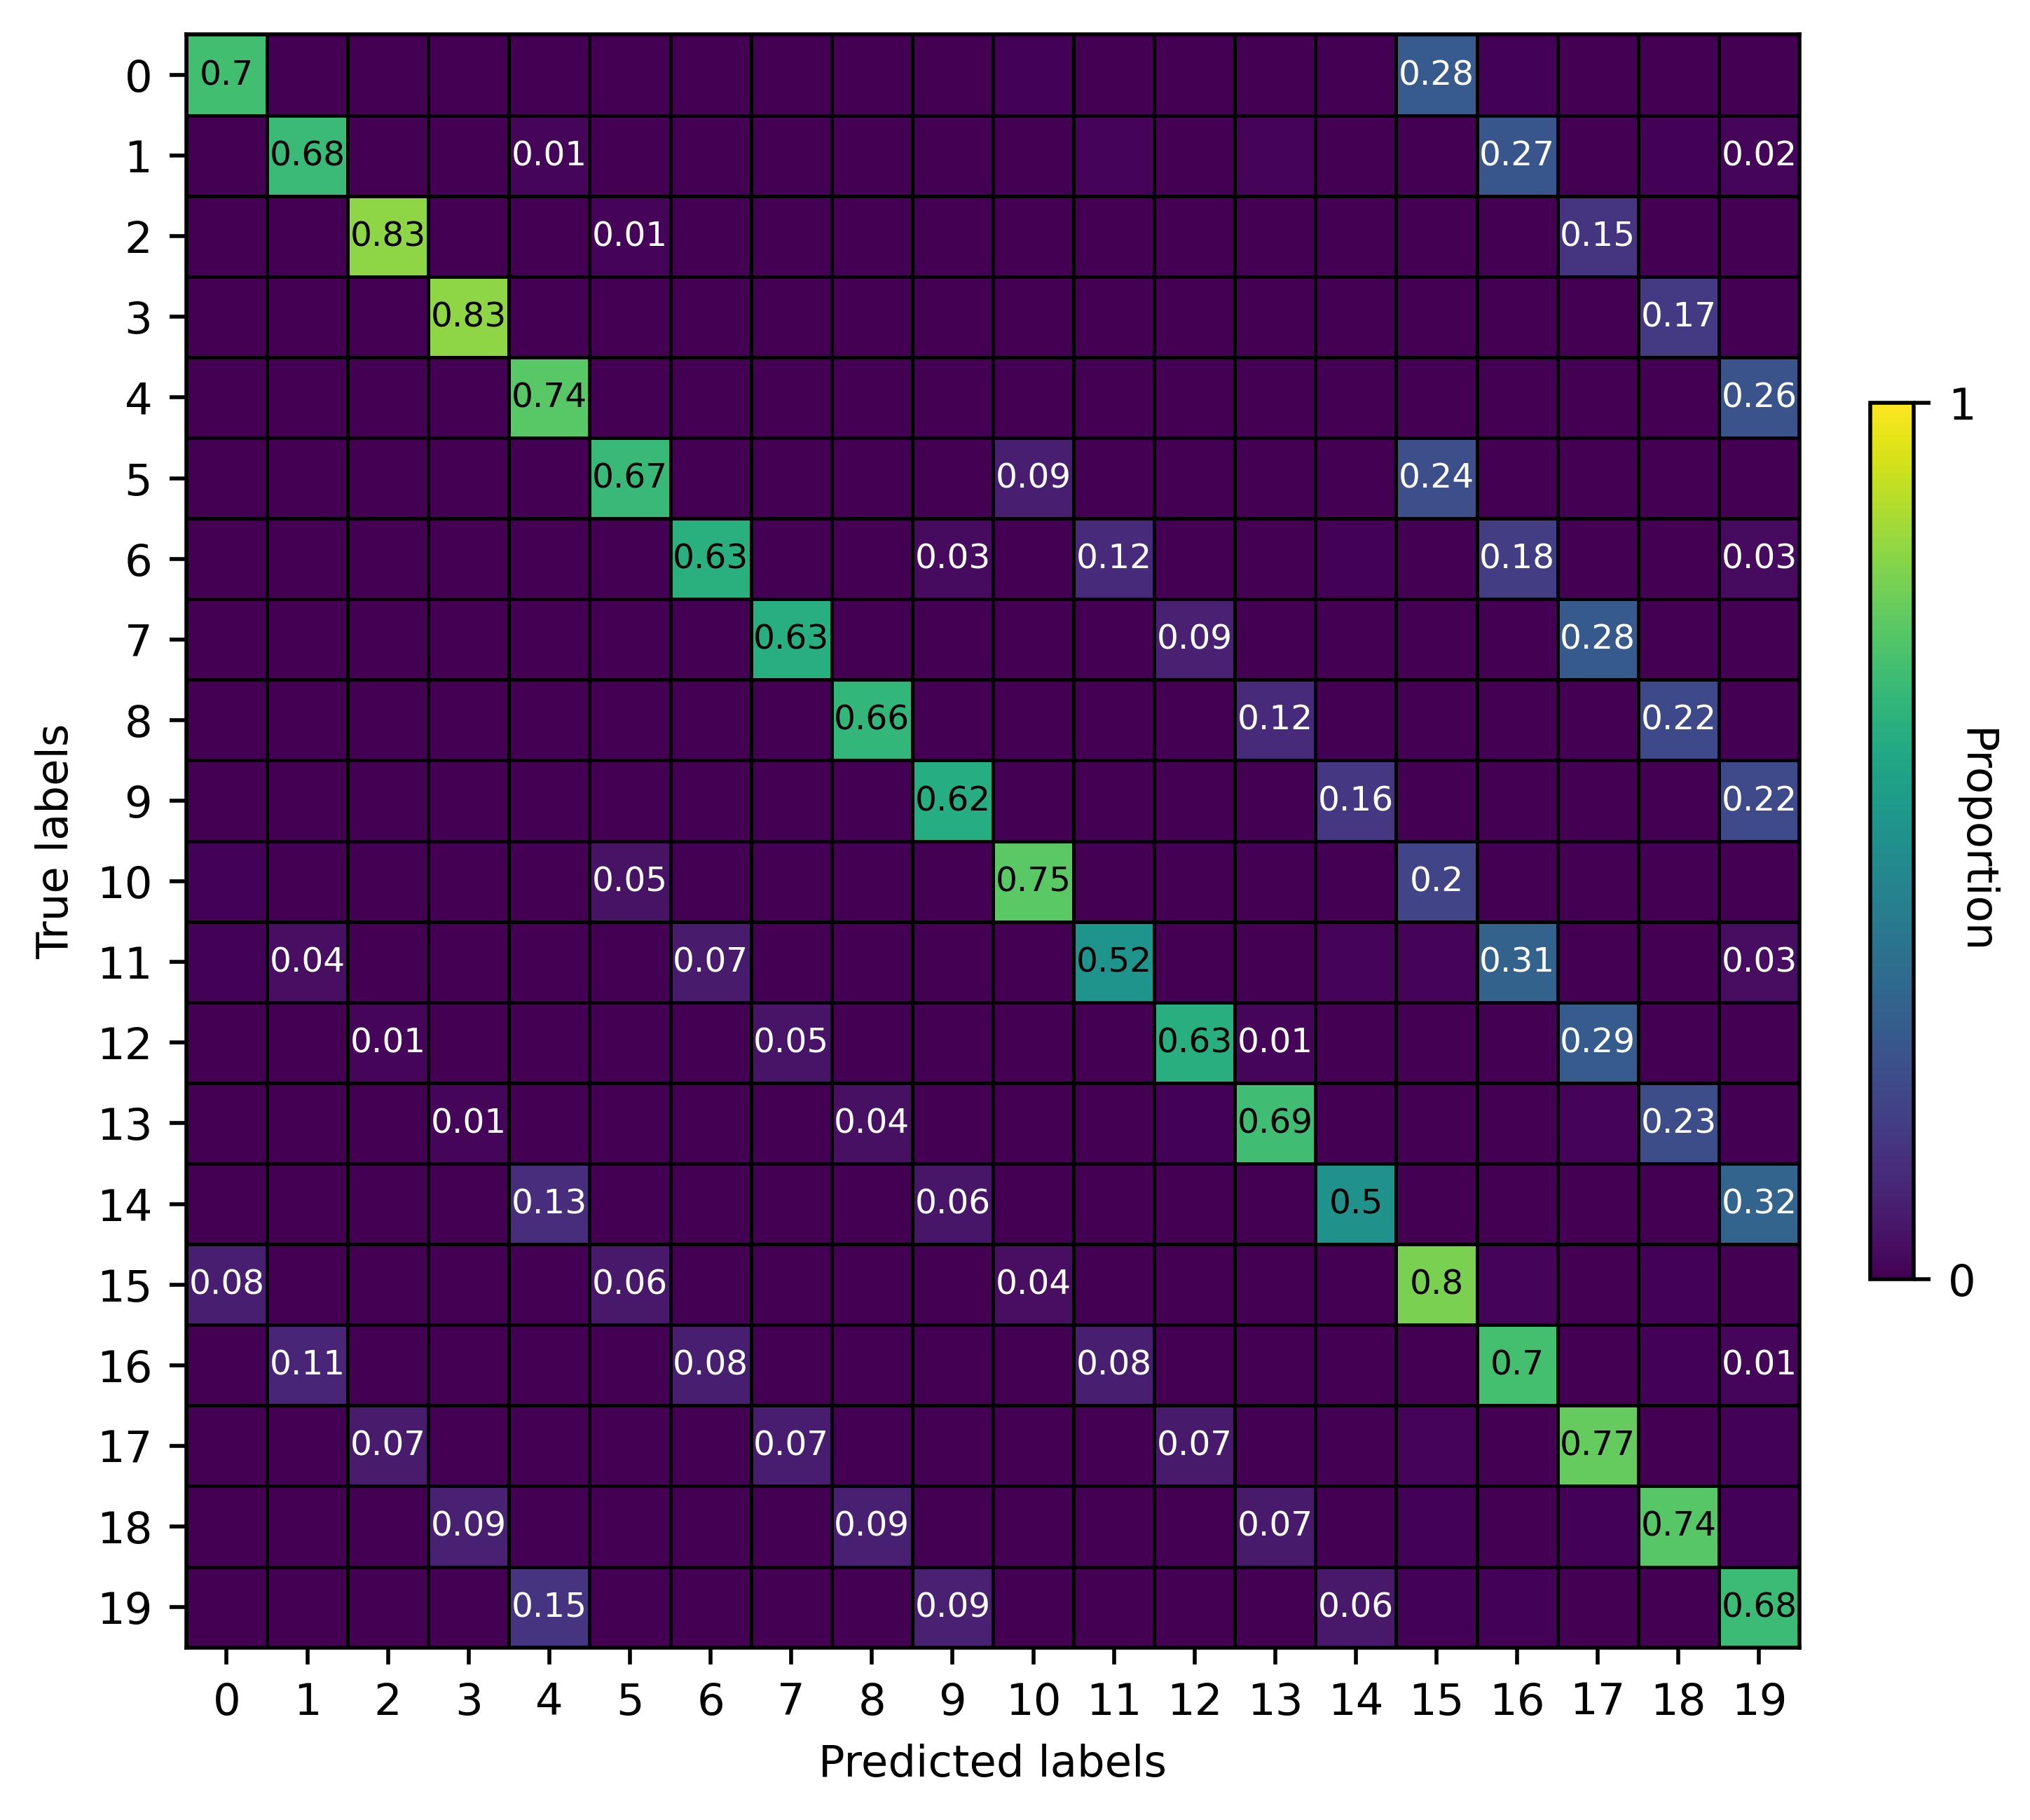

##########
# TASK 4 #
##########
Outliers: 59, 62

        accuracy
count  71.000000
mean    0.783580
std     0.082864
min     0.407960
25%     0.747287
50%     0.794956
75%     0.839483
max     0.944810
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     10187
           1       0.74      0.80      0.77      5090
           2       0.83      0.87      0.85      5107
           3       0.79      0.91      0.85      5101
           4       0.63      0.88      0.73      5097
           5       0.71      0.67      0.69     10049
           6       0.78      0.64      0.70      5003
           7       0.76      0.72      0.74      5027
           8       0.87      0.71      0.78      4955
           9       0.77      0.62      0.69      5018
          10       0.77      0.77      0.77     10098
          11       0.72      0.69      0.70      5028
          12       0.74      0.76      0.75      4966
          13       0.77      0.82      

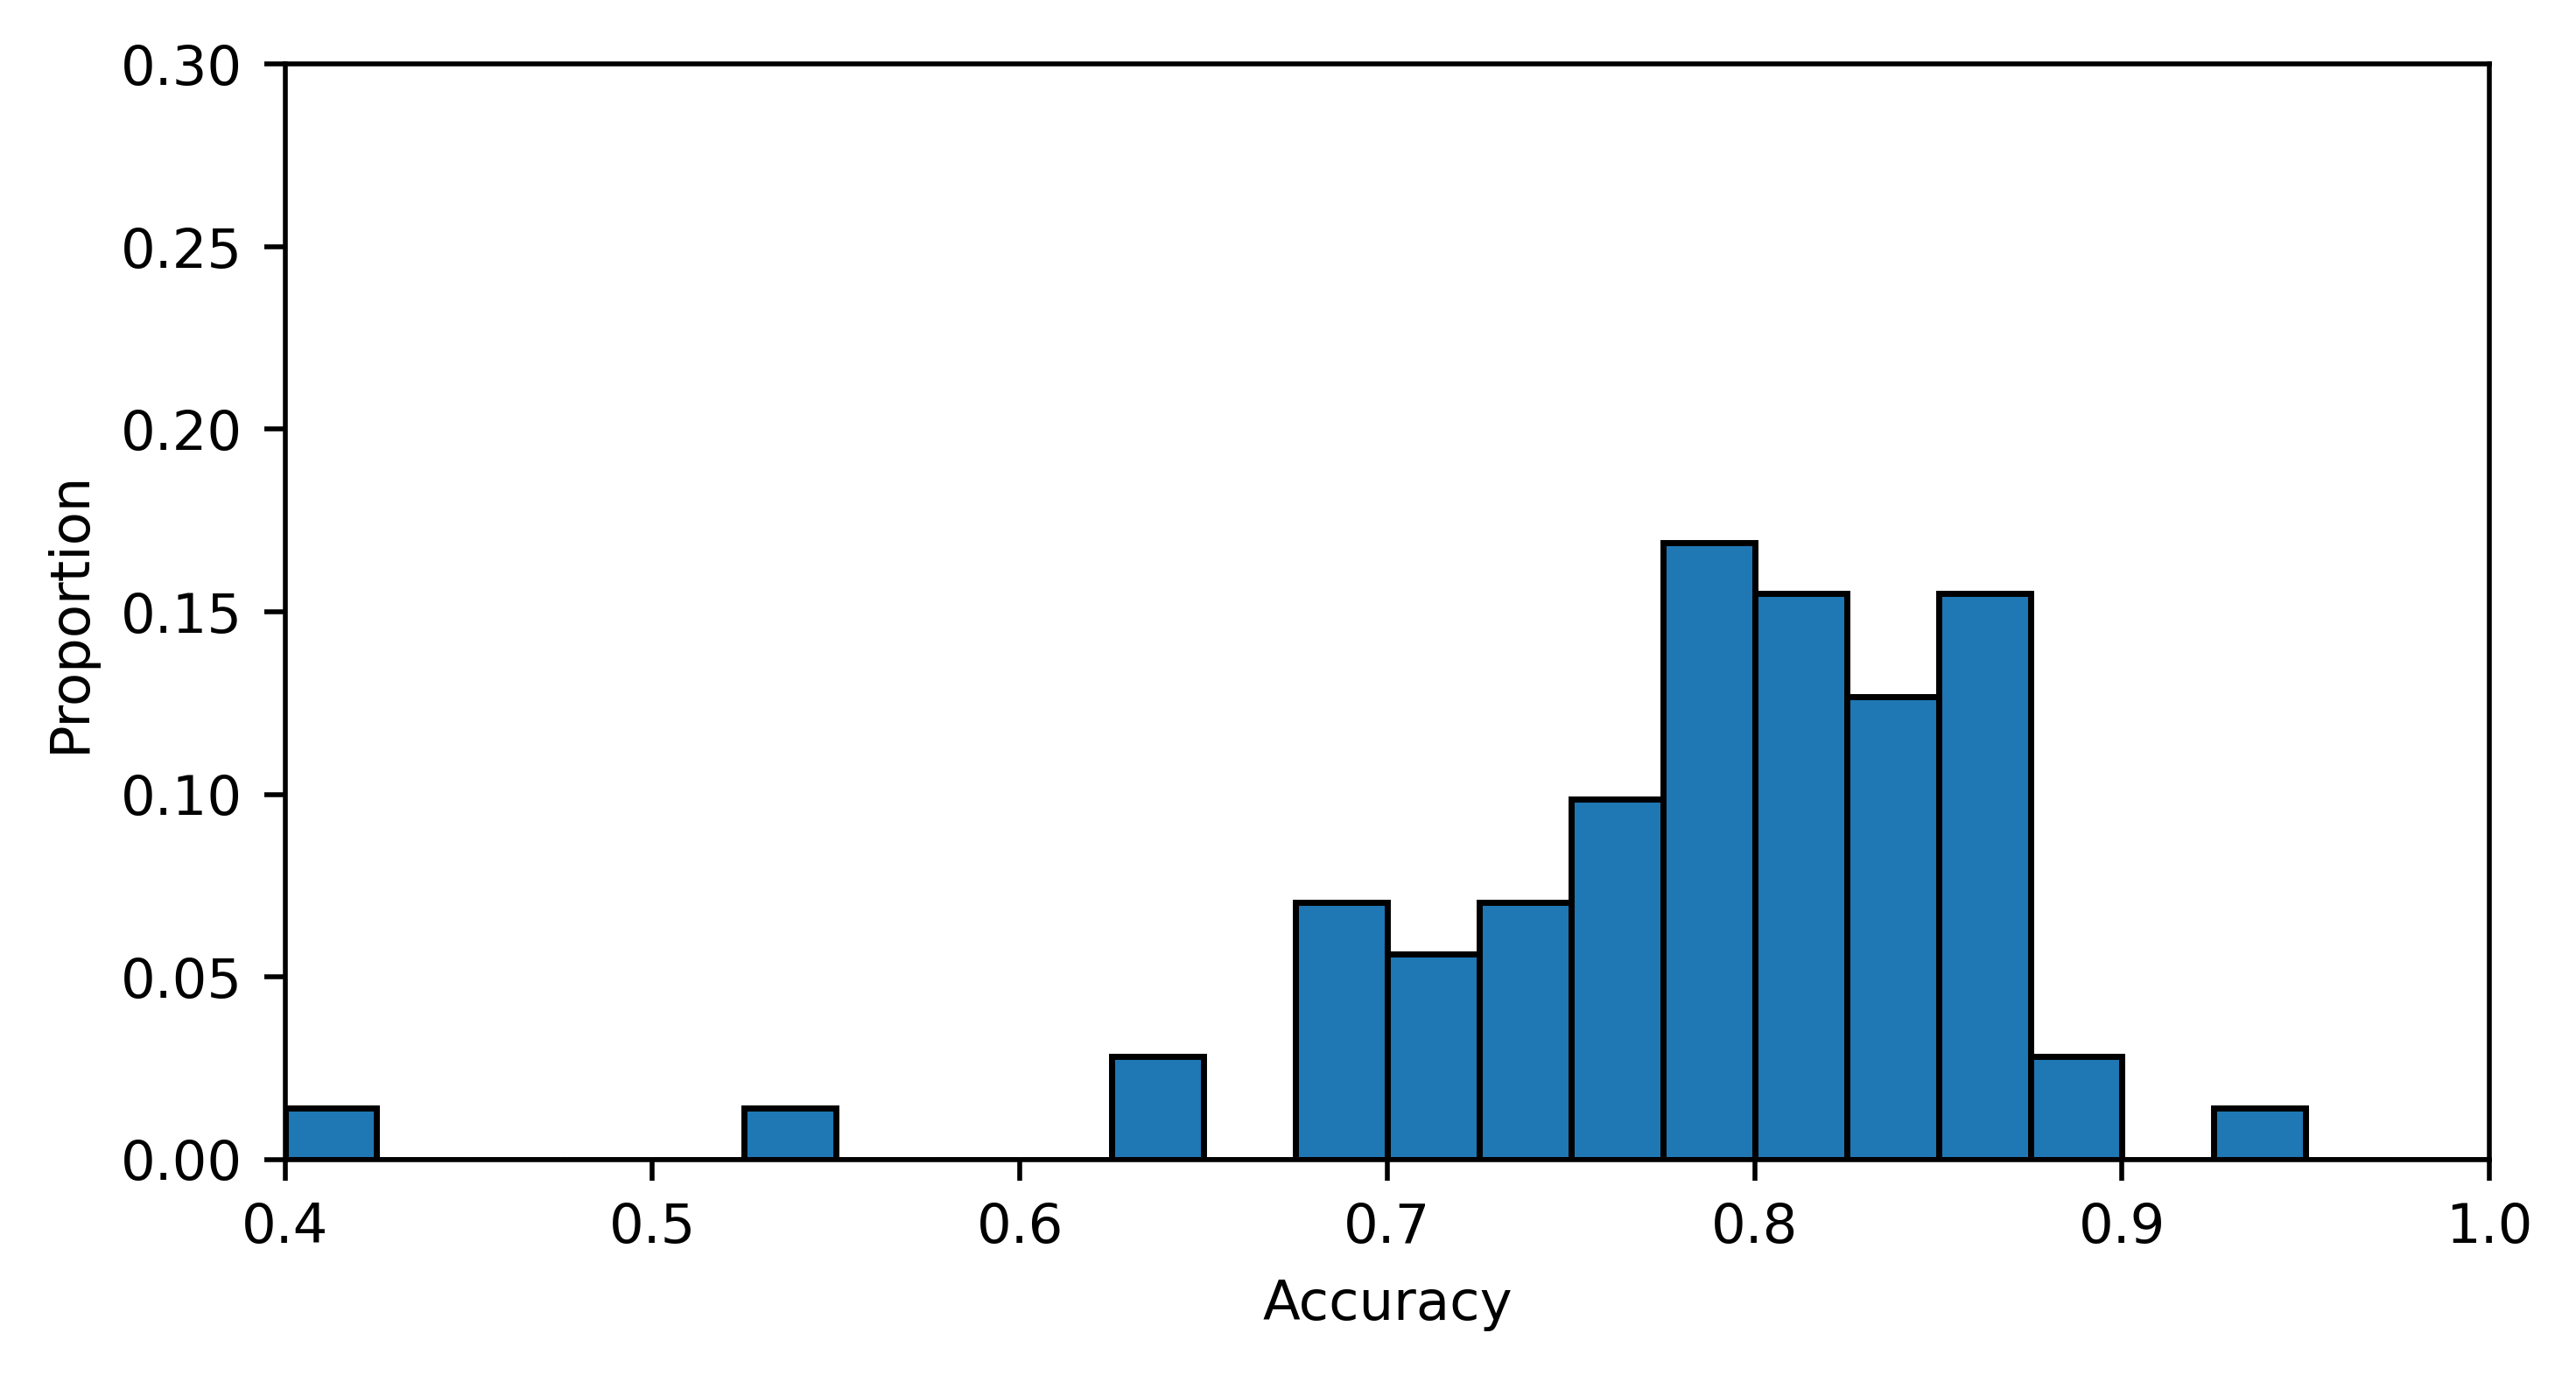

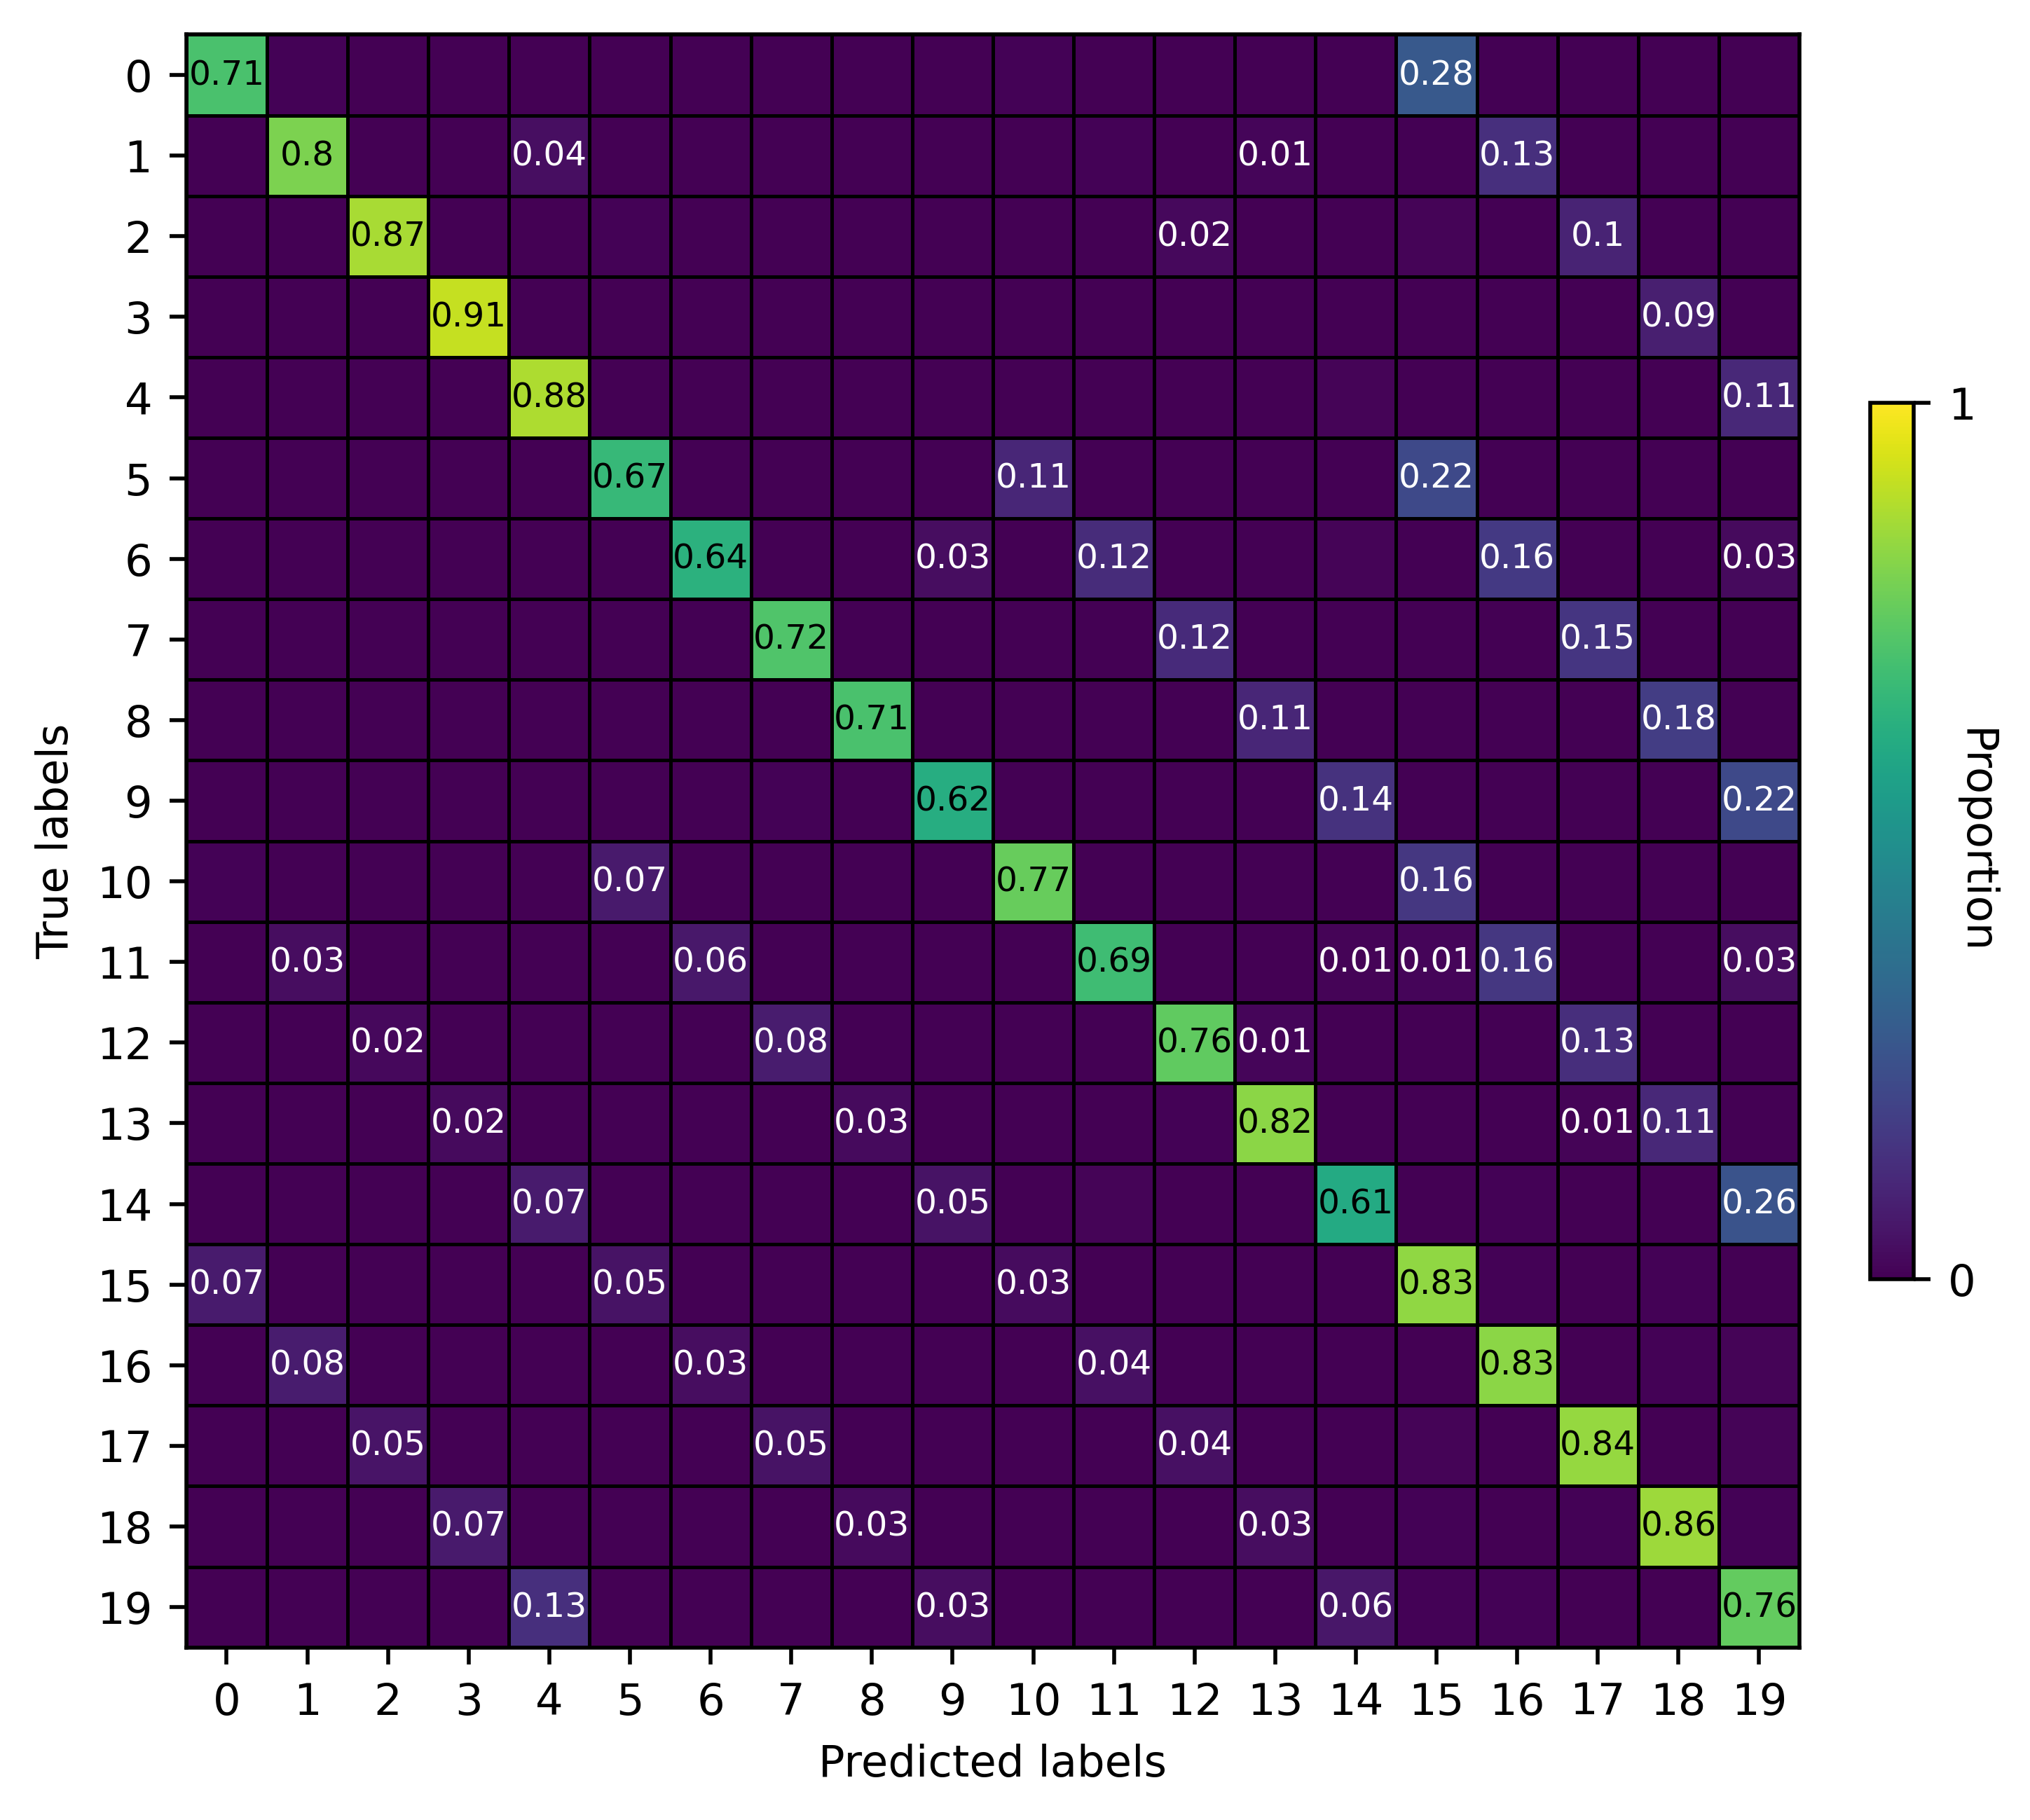

In [5]:
save_fig = True

for i in range(1, 5):
    print("##########")
    print(f"# TASK {i} #")
    print("##########")

    task_df = load_task_df(i)
    acc_df = loo_accuracy(task_df)
    task_clean_df = filter_outliers(task_df)

    print(acc_df.describe())
    print(classification_report(task_df['true'], task_df['pred']))

    lower_bound = math.floor(acc_df.accuracy.min() * 10.0) / 10.0
    plot_acc_hist(task_df, lower_bound=lower_bound, save_fig=save_fig, filename=f'task_{i}_acc_hist.pdf')
    plot_classification_report(task_df, save_fig=save_fig, filename=f'task_{i}_class_report.pdf')